In [1]:
from lsst.afw.image import ExposureFitsReader

In [2]:
original_exposure = ExposureFitsReader("../visit_image_LSSTComCam_r_r_03_2024110800246_R22_S02_LSSTComCam_runs_DRP_DP1_v29_0_0_DM-50260_20250419T073356Z.fits").read()

In [3]:
from lsst.obs.lsst import LsstComCam

instrument = LsstComCam()

In [ ]:
from matplotlib import pyplot
import numpy as np
from lsst.geom import Box2D, Point2D, degrees
from lsst.afw.geom import makeSkyWcs

In [5]:
%matplotlib widget

In [31]:
corner_sky = original_exposure.wcs.pixelToSky(Point2D(0.0, 0.0))
proj = makeSkyWcs(corner_sky.getPosition(degrees), corner_sky, np.identity(2))
bbox = Box2D(original_exposure.getBBox())
x, y = np.meshgrid(np.linspace(bbox.x.min, bbox.x.max, 200), np.linspace(bbox.y.min, bbox.y.max, 200))

In [32]:
import lsst.meas.astrom.fit_sip_approximation
from importlib import reload
reload(lsst.meas.astrom.fit_sip_approximation)
FitSipApproximationTask = lsst.meas.astrom.fit_sip_approximation.FitSipApproximationTask

In [33]:
config = FitSipApproximationTask.ConfigClass()
config.sip_order = 5
task = FitSipApproximationTask(config=config)
boresight, orientation = task.fit_pointing(true_wcs=original_exposure.wcs, detector=original_exposure.detector, instrument=instrument)

In [34]:
repointed_raw_wcs, flip_x = task.make_raw_wcs(boresight, orientation, detector=original_exposure.detector, instrument=instrument)

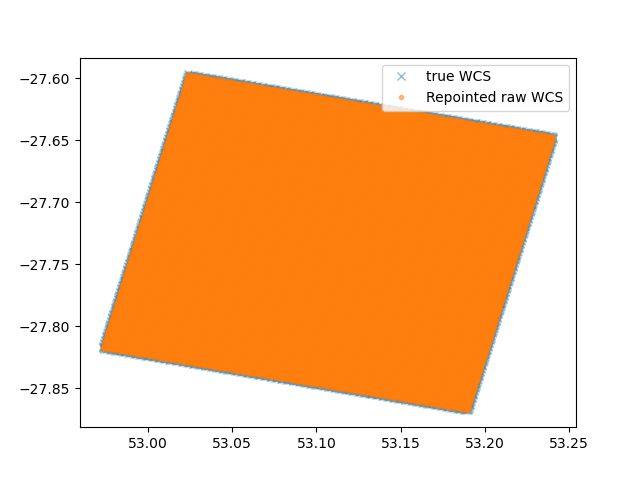

0.22939695437287355 0.24708878506771725


In [35]:
true_ra, true_dec = original_exposure.wcs.pixelToSkyArray(x.ravel(), y.ravel())
true_proj_x, true_proj_y = proj.skyToPixelArray(true_ra, true_dec)
raw_ra, raw_dec = repointed_raw_wcs.pixelToSkyArray(x.ravel(), y.ravel())
raw_proj_x, raw_proj_y = proj.skyToPixelArray(raw_ra, raw_dec)
pyplot.figure()
pyplot.plot(true_proj_x, true_proj_y, 'x', label="true WCS", alpha=0.5)
pyplot.plot(raw_proj_x, raw_proj_y, '.', label="Repointed raw WCS", alpha=0.5)

pyplot.legend()
pyplot.show()
print(np.abs(raw_proj_x - true_proj_x).max() * 3600, np.abs(raw_proj_y - true_proj_y).max() * 3600)

In [36]:
sip_approx = task.fit_sip_approximation(
    true_wcs=original_exposure.wcs, repointed_raw_wcs=repointed_raw_wcs, detector=original_exposure.detector
)

In [37]:
from lsst.afw.geom import makeTanSipMetadata, SkyWcs

md = makeTanSipMetadata(
    sip_approx.getPixelOrigin(),
    repointed_raw_wcs.getSkyOrigin(),
    sip_approx.getCdMatrix(),
    sip_approx.getA(),
    sip_approx.getB(),
    sip_approx.getAP(),
    sip_approx.getBP(),
)

fits_wcs = SkyWcs(md)


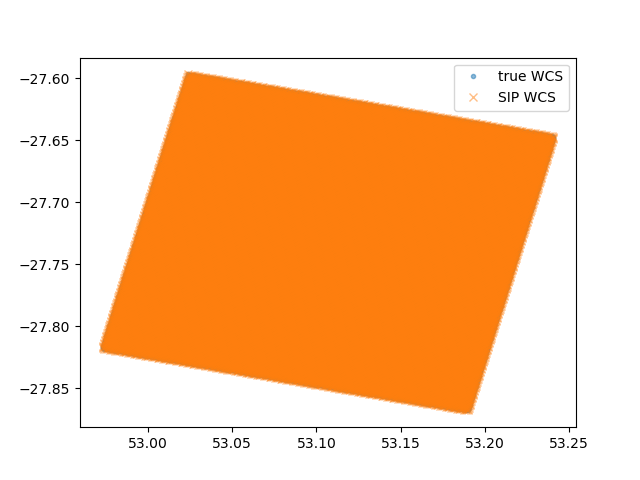

5.474021236295812e-09 2.1103119252074976e-08


In [38]:
true_ra, true_dec = original_exposure.wcs.pixelToSkyArray(x.ravel(), y.ravel())
true_proj_x, true_proj_y = proj.skyToPixelArray(true_ra, true_dec)
fits_ra, fits_dec = fits_wcs.pixelToSkyArray(x.ravel(), y.ravel())
fits_proj_x, fits_proj_y = proj.skyToPixelArray(fits_ra, fits_dec)
pyplot.figure()
pyplot.plot(true_proj_x, true_proj_y, '.', label="true WCS", alpha=0.5)
pyplot.plot(fits_proj_x, fits_proj_y, 'x', label="SIP WCS", alpha=0.5)
pyplot.legend()
pyplot.show()
print(np.abs(fits_proj_x - true_proj_x).max() * 3600, np.abs(fits_proj_y - true_proj_y).max() * 3600)

In [26]:
d_fits = fits_wcs.getFitsMetadata().toDict()
d_approx = md.toDict()

In [27]:
for key in d_fits.keys() & d_approx.keys():
    if d_fits[key] != d_approx[key]:
        print(f"{key}: {d_fits[key]} != {d_approx[key]}")

for key in d_fits.keys() - d_approx.keys():
    print(f"{key}: {d_fits[key]} (FITS only)")

for key in d_approx.keys() - d_fits.keys():
    print(f"{key}: {d_approx[key]} (SipApproximation only)")

A_1_0: 0.002170722334515318 != 0.002170722334515218
BP_0_1: -0.00025724307098839994 != -0.00025724307098836904
CRVAL2: -28.0138311123864 != -28.013831112386395
CRPIX2: 6224.638062 != 6226.5
AP_1_0: -0.002152223255959429 != -0.002152223255959412
CRPIX1: -2181.492135 != -2187.5
B_0_1: 0.00027629430734310567 != 0.00027629430734303845
WCSAXES: 2 (FITS only)
CUNIT1: deg (SipApproximation only)
CUNIT2: deg (SipApproximation only)


In [158]:
print(fits_wcs.getFrameDict().show())

 Begin FrameSet 	# Set of inter-related coordinate systems
#   Title = "ICRS coordinates; gnomonic projection" 	# Title of coordinate system
#   Naxes = 2 	# Number of coordinate axes
#   Domain = "SKY" 	# Coordinate system domain
#   Epoch = 2000 	# Julian epoch of observation
#   Lbl1 = "Right ascension" 	# Label for axis 1
#   Lbl2 = "Declination" 	# Label for axis 2
#   System = "ICRS" 	# Coordinate system type
#   Uni1 = "hh:mm:ss.s" 	# Units for axis 1
#   Uni2 = "ddd:mm:ss" 	# Units for axis 2
#   Dir1 = 0 	# Plot axis 1 in reverse direction
#   Bot2 = -1.5707963267948966 	# Lowest legal axis value
#   Top2 = 1.5707963267948966 	# Highest legal axis value
 IsA Frame 	# Coordinate system description
    Nframe = 3 	# Number of Frames in FrameSet
#   Base = 1 	# Index of base Frame
    Currnt = 3 	# Index of current Frame
    Lnk2 = 1 	# Node 2 is derived from node 1
    Lnk3 = 2 	# Node 3 is derived from node 2
    Frm1 = 	# Frame number 1
       Begin Frame 	# Coordinate system 

In [28]:
import astropy.io.fits

header = astropy.io.fits.Header(fits_wcs.getFitsMetadata().toDict())

In [29]:
header

WCSAXES =                    2                                                  
CRPIX1  =         -2181.492135                                                  
CRPIX2  =          6224.638062                                                  
CRVAL1  =   53.324335293298184                                                  
CRVAL2  =    -28.0138311123864                                                  
CTYPE1  = 'RA---TAN-SIP'                                                        
CTYPE2  = 'DEC--TAN-SIP'                                                        
CD1_1   = 1.23404884930399E-05                                                  
CD1_2   = 5.42192824331549E-05                                                  
CD2_1   = 5.42192824330686E-05                                                  
CD2_2   = -1.2340488493059E-05                                                  
RADESYS = 'ICRS    '                                                            
A_0_0   =   -6.0463916351443